In [2]:
import torch
from torch import nn
from msdm.algorithms.entregpolicyiteration import entropy_regularized_policy_iteration
import matplotlib.pyplot as plt
import numpy as np
from frozendict import frozendict
from msdm.domains import GridWorld
from softmax_policy import TabularPolicy
from msdm.core.distributions import DictDistribution
from dataset import FeaturesDataset
from algorithms import ImitationLearning

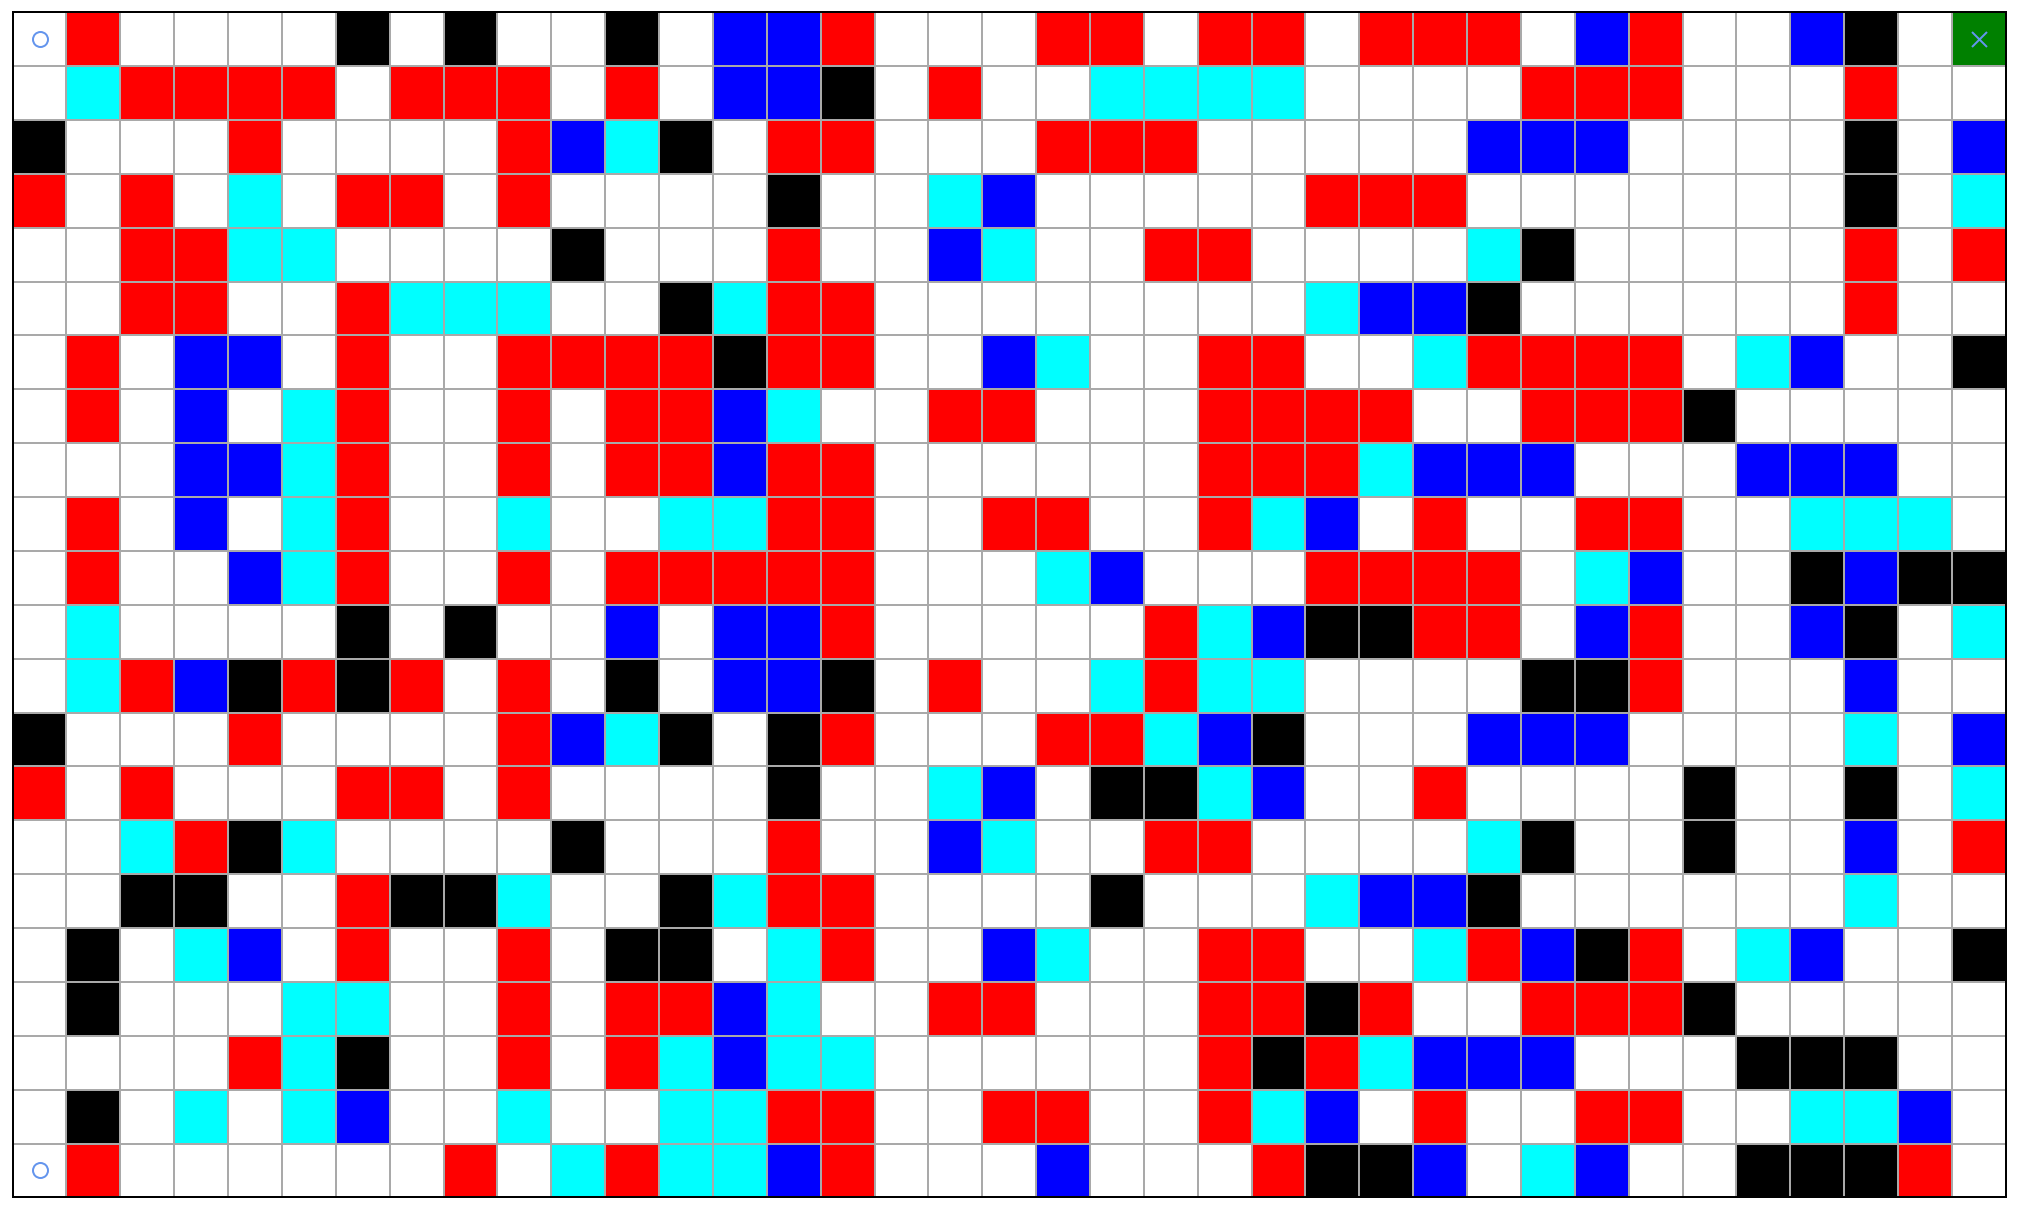

In [3]:
# Create a gridworld
mdp_params = dict(
    tile_array=[
        "sx....c.c..c.bbx...xx.xx.xxx.bx..bc.g",
        ".axxxx.xxx.x.bbc.x..aaaa....xxx...x..",
        "c...x....xbac.xx...xxx.....bbb....c.b",
        "x.x.a.xx.x....c..ab.....xxx.......c.a",
        "..xxaa....c...x..ba..xx....ac.....x.x",
        "..xx..xaaa..caxx........abbc......x..",
        ".x.bb.x..xxxxcxx..ba..xx..axxxx.ab..c",
        ".x.b.ax..x.xxba..xx...xxxx..xxxc.....",
        "...bbax..x.xxbxx......xxxabbb...bbb..",
        ".x.b.ax..a..aaxx..xx..xab.x..xx..aaa.",
        ".x..bax..x.xxxxx...ab...xxxx.ab..cbcc",
        ".a....c.c..b.bbx.....xabccxx.bx..bc.a",
        ".axbcxcx.x.c.bbc.x..axaa....ccx...b..",
        "c...x....xbac.cx...xxabc...bbb....a.b",
        "x.x...xx.x....c..ab.ccab..x....c..c.a",
        "..axca....c...x..ba..xx....ac..c..b.x",
        "..cc..xcca..caxx....c...abbc......a..",
        ".c.ab.x..x.cc.ax..ba..xx..axbcx.ab..c",
        ".c...aa..x.xxba..xx...xxcx..xxxc.....",
        "....xac..x.xabaa......xcxabbb...ccc..",
        ".c.a.ab..a..aaxx..xx..xab.x..xx..aab.",
        "sx......x.axaabx...b...xccb.ab..cccx.",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=1-1e-5,
    step_cost=-1
)
mdp = GridWorld(**mdp_params)

featurecolors = {
    'g': 'green',
    'x': 'red',
    '.': 'white',
    'b': 'blue',
    'a': 'cyan',
    'c': 'black'
}
mdp.plot(featurecolors=featurecolors)


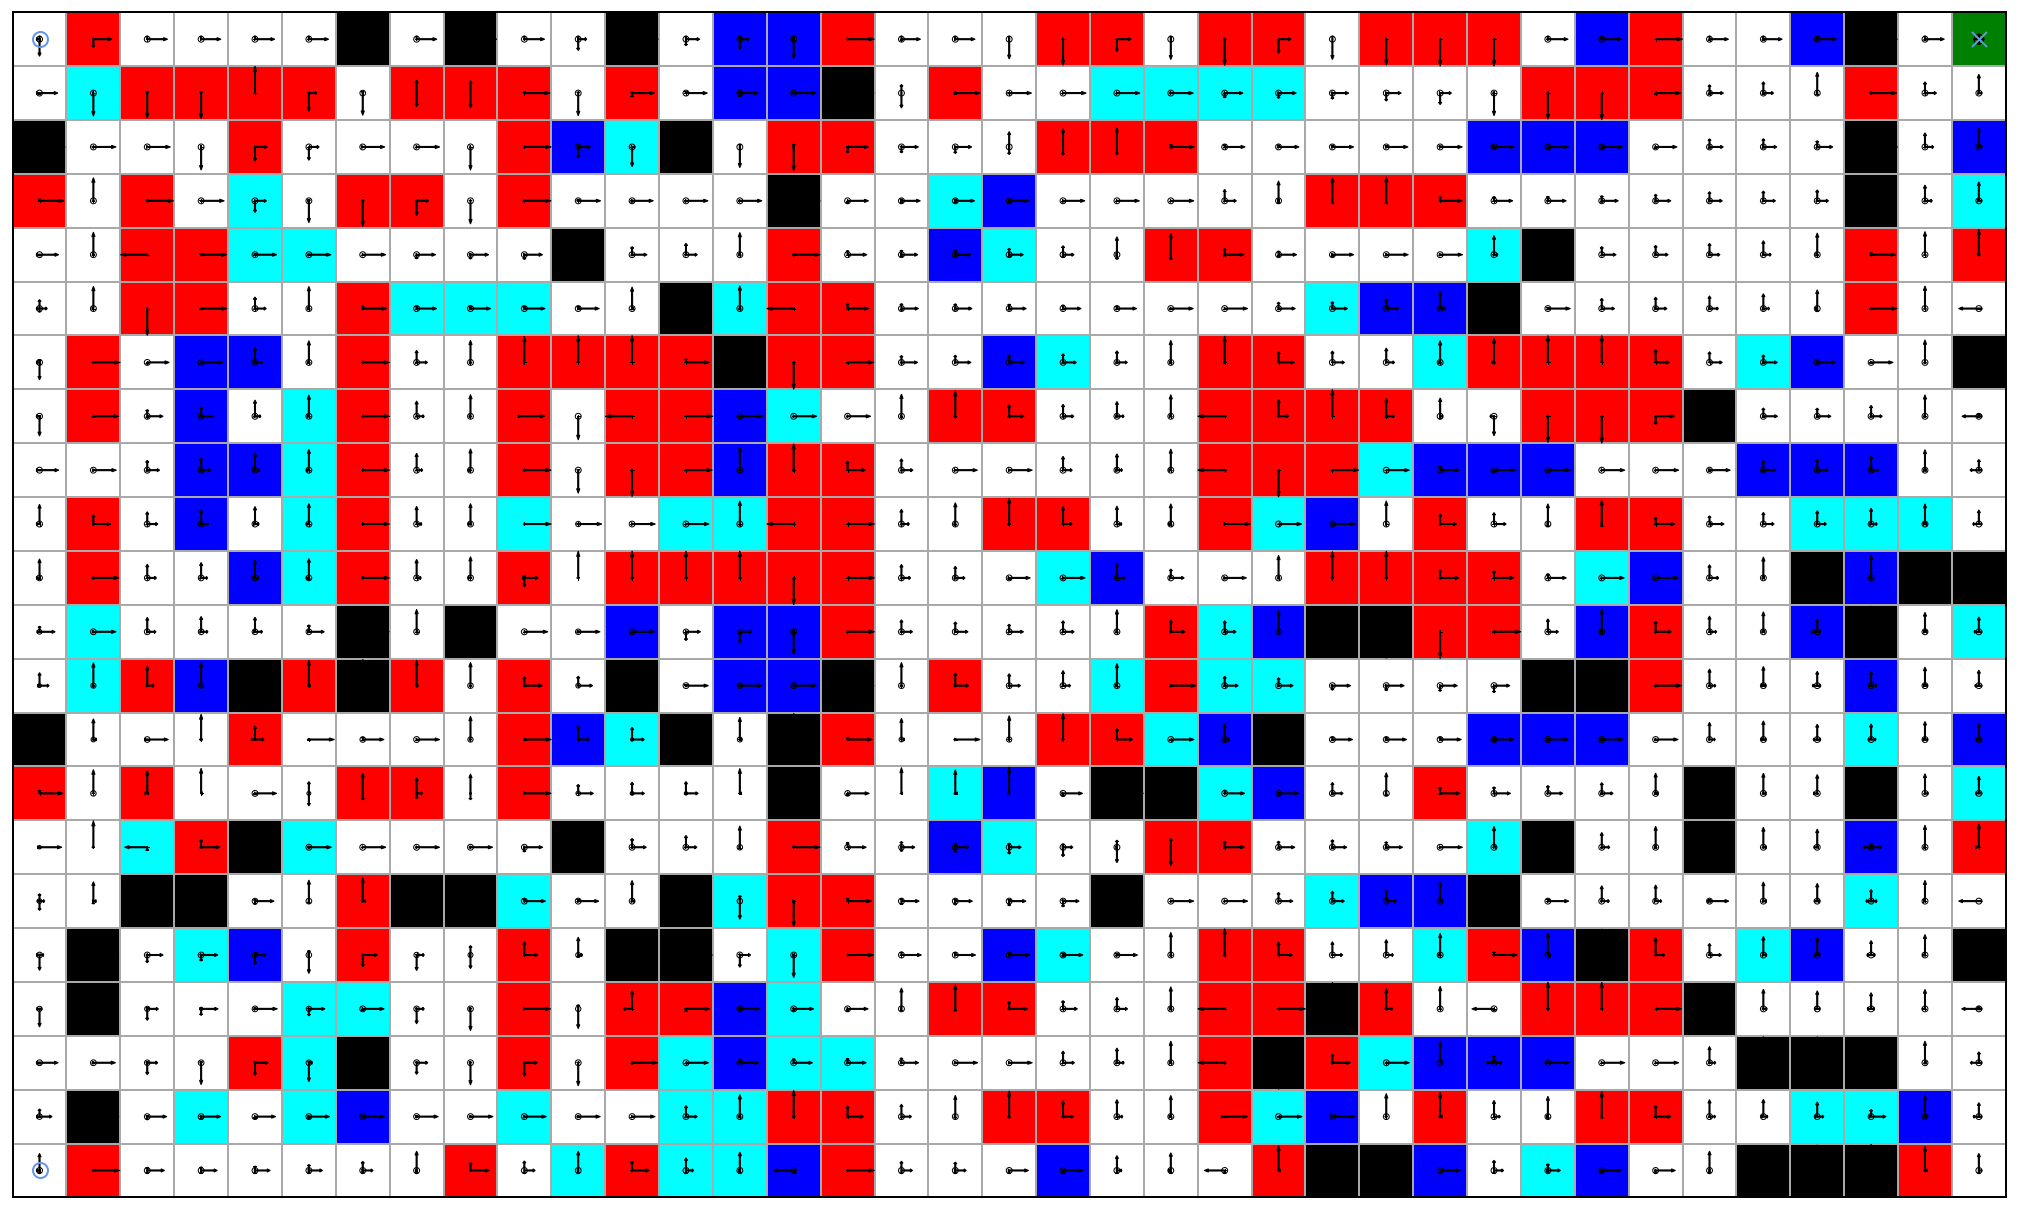

In [4]:
# Use the Maximum Entropy IRL policy to generate trajectories
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp.transition_matrix),
    reward_matrix=torch.tensor(mdp.reward_matrix),
    discount_rate=torch.tensor(mdp.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([2]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)

In [5]:
print(expert_policy.evaluate_on(mdp).initial_value)

-67.59353561963324


In [6]:
# Convert our numpy 2d array to a tensor for training
# do I need to convert the labels to a tensor? yes, does it for us in Lambda (target_transform)
class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""

  def __call__(self, sample):
    return torch.from_numpy(sample)


In [7]:
#### Need to create a ML model, train, classify, and evaluate test loss

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


class ActionClassifier(nn.Module):
  def __init__(self):
    super(ActionClassifier, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv1d(1, 16, 3, padding=1),
        nn.BatchNorm1d(16),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv1d(16, 32, 3, padding=1),
        nn.BatchNorm1d(32),
        nn.ReLU()
    )
    self.conv3 = nn.Sequential(
        nn.Conv1d(32, 64, 3, stride=2, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU()
    )
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 5),
    )
    # don't use softmax bc nn.CrossEntropyLoss takes unnormalized outputs
    # self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x_conv1 = self.conv1(x)
    x_conv2 = self.conv2(x_conv1)
    x_conv3 = self.conv3(x_conv2)
    x_flat = self.flatten(x_conv3)
    logits = self.linear_relu_stack(x_flat)
    # probabilities = self.softmax(logits)
    return logits


model = ActionClassifier().to(device)
print(model)

Using cuda device
ActionClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [8]:
# Generate gen_iters of trajectories
gen_iters = 10000
trajectories = []

for _ in range(gen_iters):
  # Starts at one of the labelled starting points
  trajectory = expert_policy.run_on(mdp)
  formatted_traj = {}
  formatted_traj['state_traj'] = trajectory.state_traj
  formatted_traj['action_traj'] = trajectory.action_traj
  trajectories.append(formatted_traj)

features_dataset = FeaturesDataset(mdp, trajectories, transform=ToTensor())


In [9]:
# Use Cross Entropy Loss for classification
loss_fn = nn.CrossEntropyLoss()

# better optimizer with a scheduler to decrease learning rate by 0.1 at indicated steps
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2, 4, 7, 9], gamma=0.1)
epochs = 10
batch_size = 128

In [10]:
supervised_learning = ImitationLearning(mdp, _, _, model, loss_fn, optimizer, scheduler=scheduler, batch_size=batch_size, epochs=epochs)
optimized_model = supervised_learning.learn(features_dataset)

Using cuda

Epoch 1
-------------------------------
loss: 1.571681  [    0/686229]

Epoch 2
-------------------------------
loss: 0.995931  [    0/686229]

Epoch 3
-------------------------------
loss: 0.933218  [    0/686229]

Epoch 4
-------------------------------
loss: 0.911465  [    0/686229]

Epoch 5
-------------------------------
loss: 0.823720  [    0/686229]

Epoch 6
-------------------------------
loss: 0.775853  [    0/686229]

Epoch 7
-------------------------------
loss: 0.667277  [    0/686229]

Epoch 8
-------------------------------
loss: 0.933359  [    0/686229]

Epoch 9
-------------------------------
loss: 0.963674  [    0/686229]

Epoch 10
-------------------------------
loss: 0.897561  [    0/686229]

Done!


Learned Policy Initial Value: -765.0667175894389

Softmax Policy Initial Value: -67.59353561963324


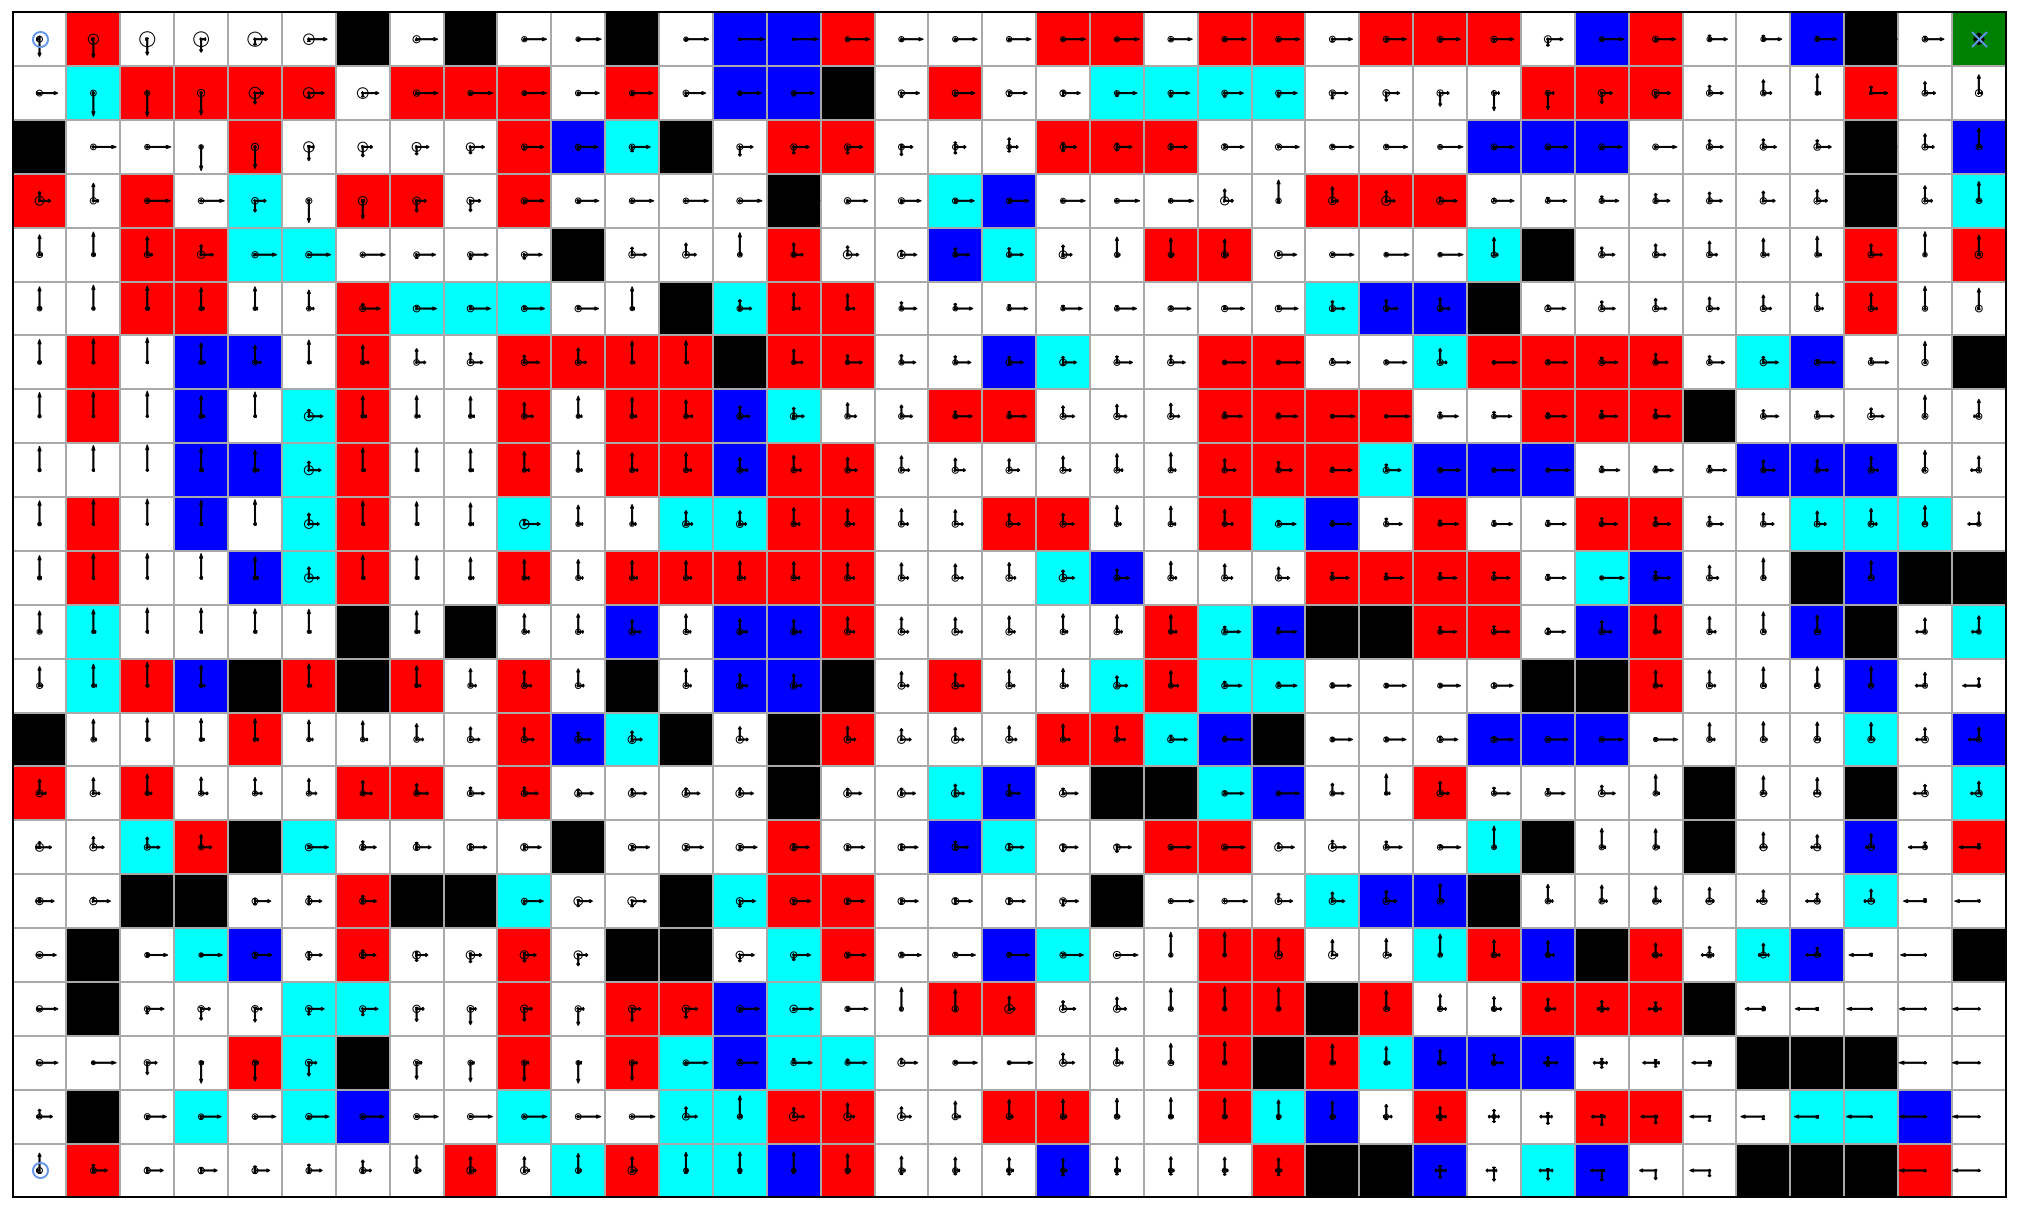

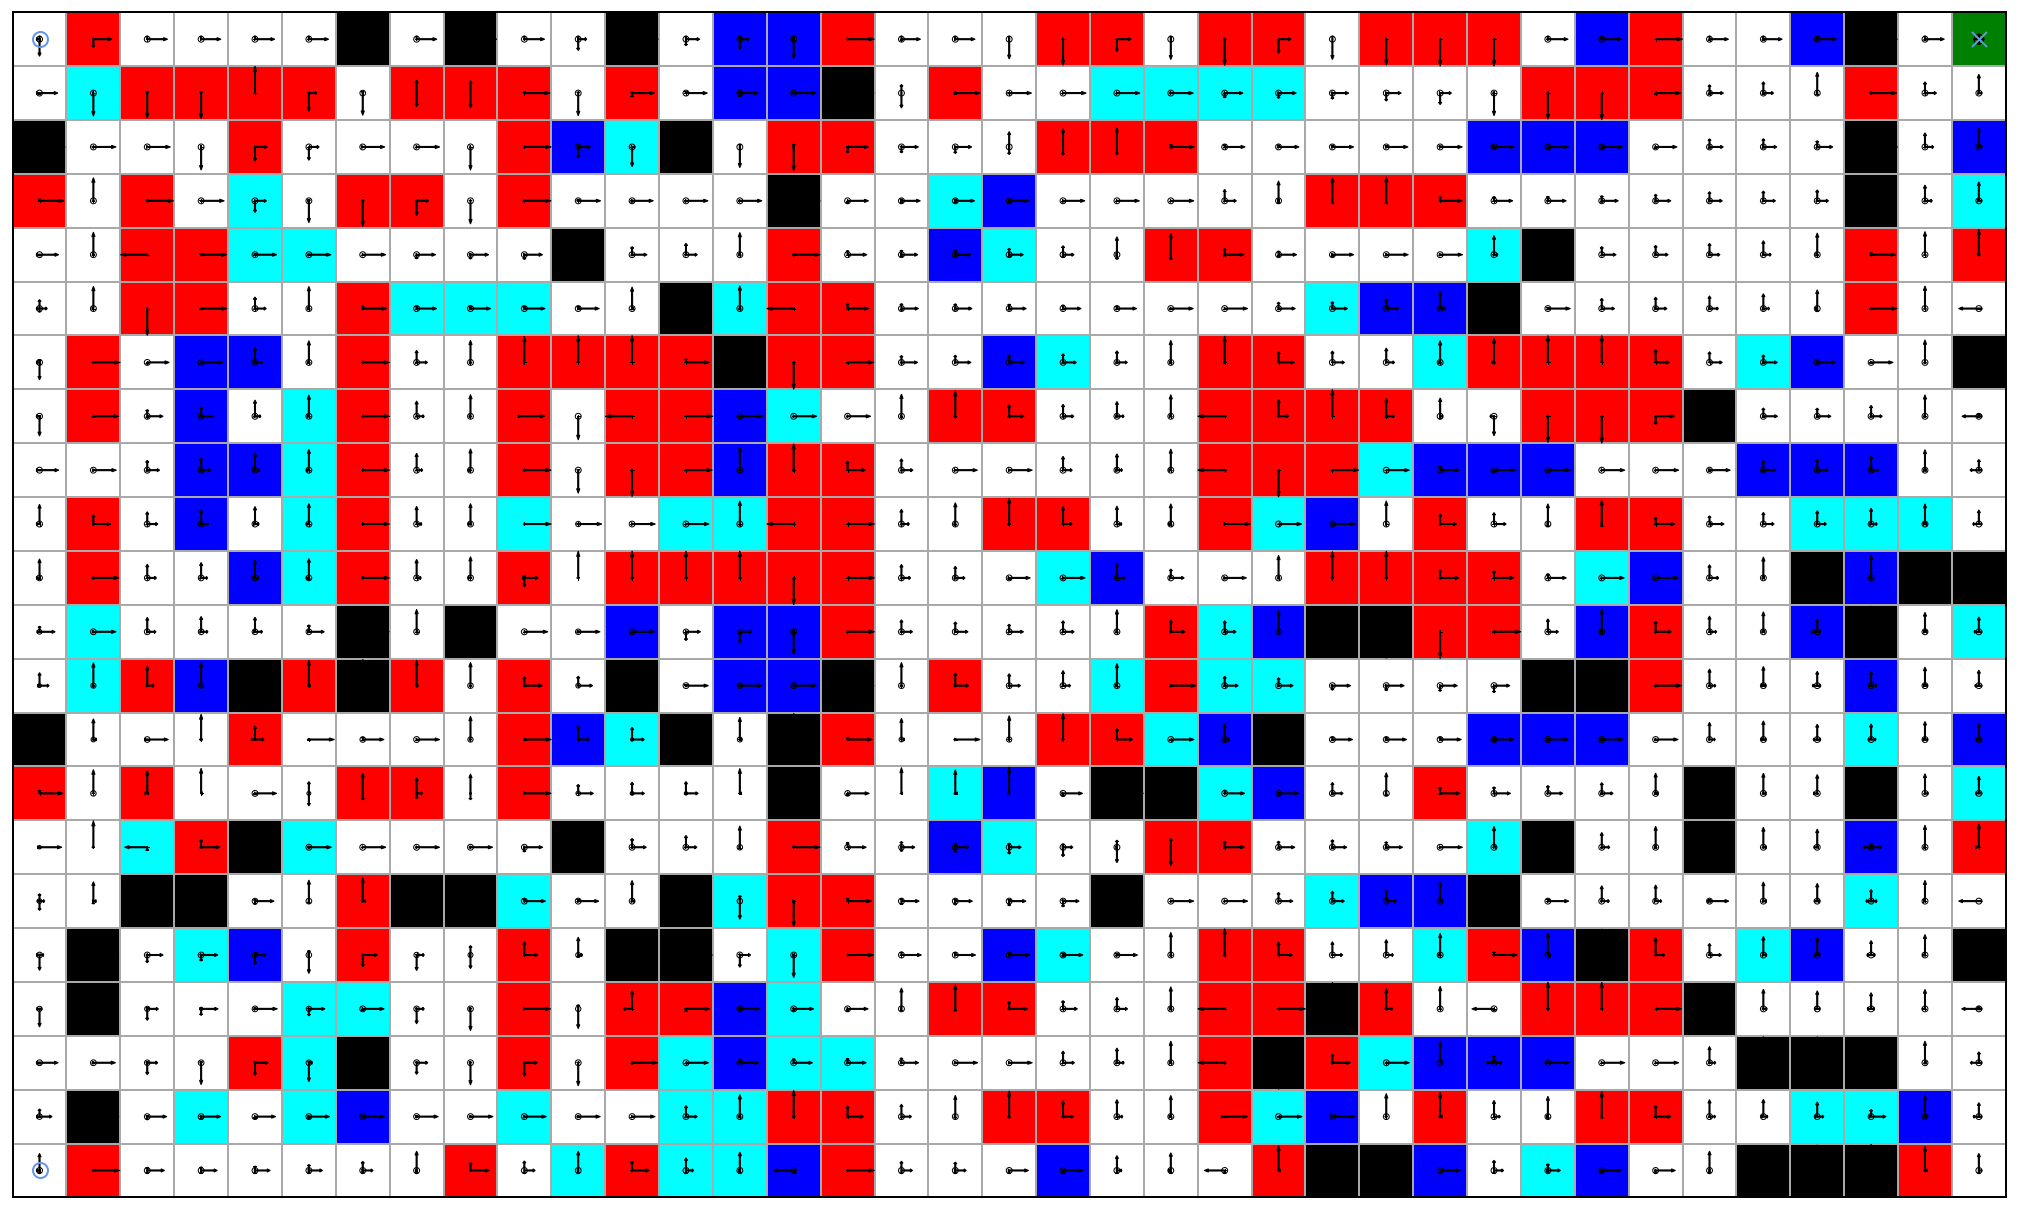

In [11]:
optimized_model.eval()

policy = {}
# int_to_action = {0: "up", 1: "down", 2: "right", 3: "left", 4: "stay"}
int_to_action = {0: frozendict(dx=0, dy=1), 1: frozendict(
    dx=0, dy=-1), 2: frozendict(dx=1, dy=0), 3: frozendict(dx=-1, dy=0), 4: frozendict(dx=0, dy=0)}

softmax_fn = nn.Softmax(dim=1)

# so pred doesn't have a grad_fn attached to it
with torch.no_grad():
  for s in mdp.state_list:
    state_feature = torch.from_numpy(np.array([features_dataset.getStateFeature(s)], dtype='f')).to(device)
    # pred = model(state_feature)[0]
    # pred = supervised_learning.model(state_feature)
    pred = optimized_model(state_feature)
    probs = softmax_fn(pred)[0]
    policy[s] = {}
    # for each action in each state, grab from the "pred" result the probability of taking this action in this state and add that to the dictionary policy which is a dictionary with states as keys and a dictionary of "action: prob of taking this action in this state" as values
    for a_i, prob in enumerate(probs):
      policy[s][int_to_action[a_i]] = prob.item()

# to turn policy into an actual policy object that we can call the MSDM functions on
policy = TabularPolicy({s: DictDistribution(ap) for s, ap in policy.items()})
mdp.plot(featurecolors=featurecolors).plot_policy(policy)
mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
print(f"Learned Policy Initial Value: {policy.evaluate_on(mdp).initial_value}")
print()
print(f"Softmax Policy Initial Value: {expert_policy.evaluate_on(mdp).initial_value}")


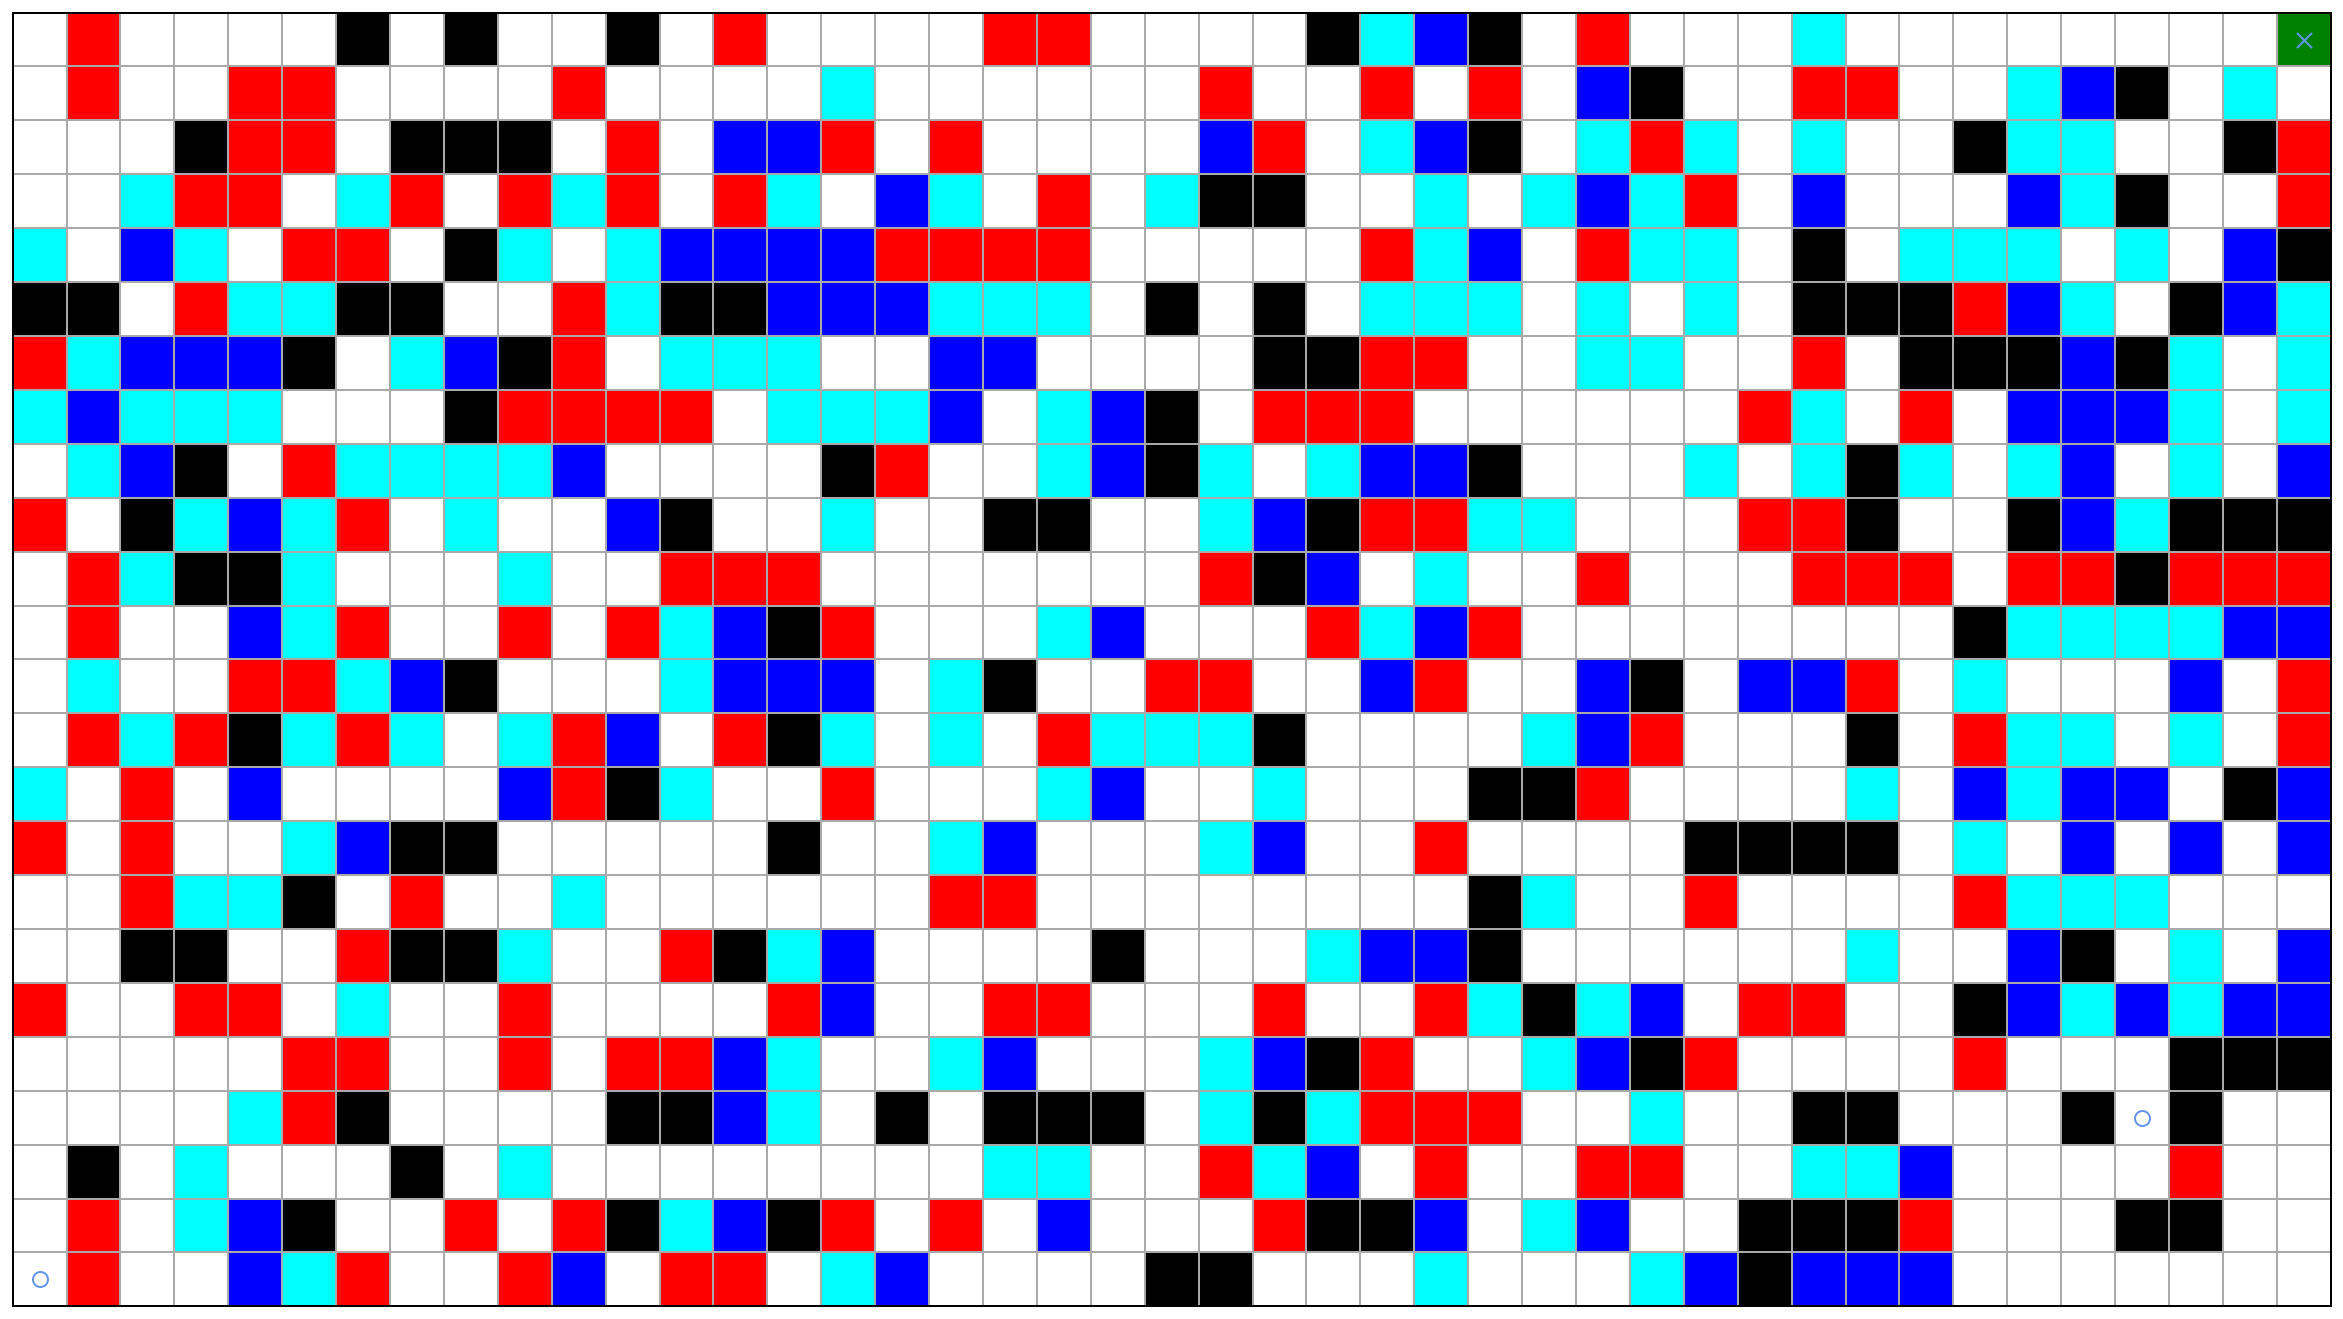

In [15]:
# Test learned reward weights on a novel gridworld
mdp2_params = dict(
    tile_array=[
        ".x....c.c..c.x....xx....cabc.x...a........g",
        ".x..xx....x....a......x..x.x.bc..xx..abc.a.",
        "...cxx.ccc.x.bbx.x....bx.abc.axa.a..caa..cx",
        "..axx.ax.xax.xa.ba.x.acc..a.abax.b...bac..x",
        "a.ba.xx.ca.abbbbxxxx.....xab.xaa.c.aaa.a.bc",
        "cc.xaacc..xaccbbbaaa.c.c.aaa.a.a.cccxba.cba",
        "xabbbc.abcx.aaa..bb....ccxx..aa..x.cccbca.a",
        "abaaa...cxxxx.aaab.abc.xxx......xa.x.bbba.a",
        ".abc.xaaaab....cx..abca.abbc...a.aca.ab.a.b",
        "x.cabax.a..bc..a..cc..abcxxaa...xxc..cbaccc",
        ".xacca...a..xxx.......xcb.a..x...xxx.xxcxxx",
        ".x..bax..x.xabcx...ab...xabx........caaaabb",
        ".a..xxabc...abbb.ac..xx..bx..bc.bbx.a...b.x",
        ".xaxcaxa.axb.xca.a.xaaac....abx...c.xaa.a.x",
        "a.x.b....bxca..x...ab..a...ccx....a.babb.cb",
        "x.x..abcc.....c..ab...ab..x....cccc.a.b.b.b",
        "..xaac.x..a......xx........ca..x....xaaa...",
        "..cc..xcca..xcab....c...abbc......a..bc.a.b",
        "x..xx.a..x....xb..xx...x..xacab.xx..cbababb",
        ".....xx..x.xxba..ab...abcx..abcx....x...ccc",
        "....axc....ccba.c.ccc.acaxxx..a..cc...csc..",
        ".c.a...c.a........aa..xab.x..xx..aab....x..",
        ".x.abc..x.xcabcx.x.b...xccb.ab..cccx...cc..",
        "sx..bax..xb.xx.ab....cc...a...abcbbb.......",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=1-1e-5,
    step_cost=-1
)
mdp2 = GridWorld(**mdp2_params)

mdp2.plot(featurecolors=featurecolors)


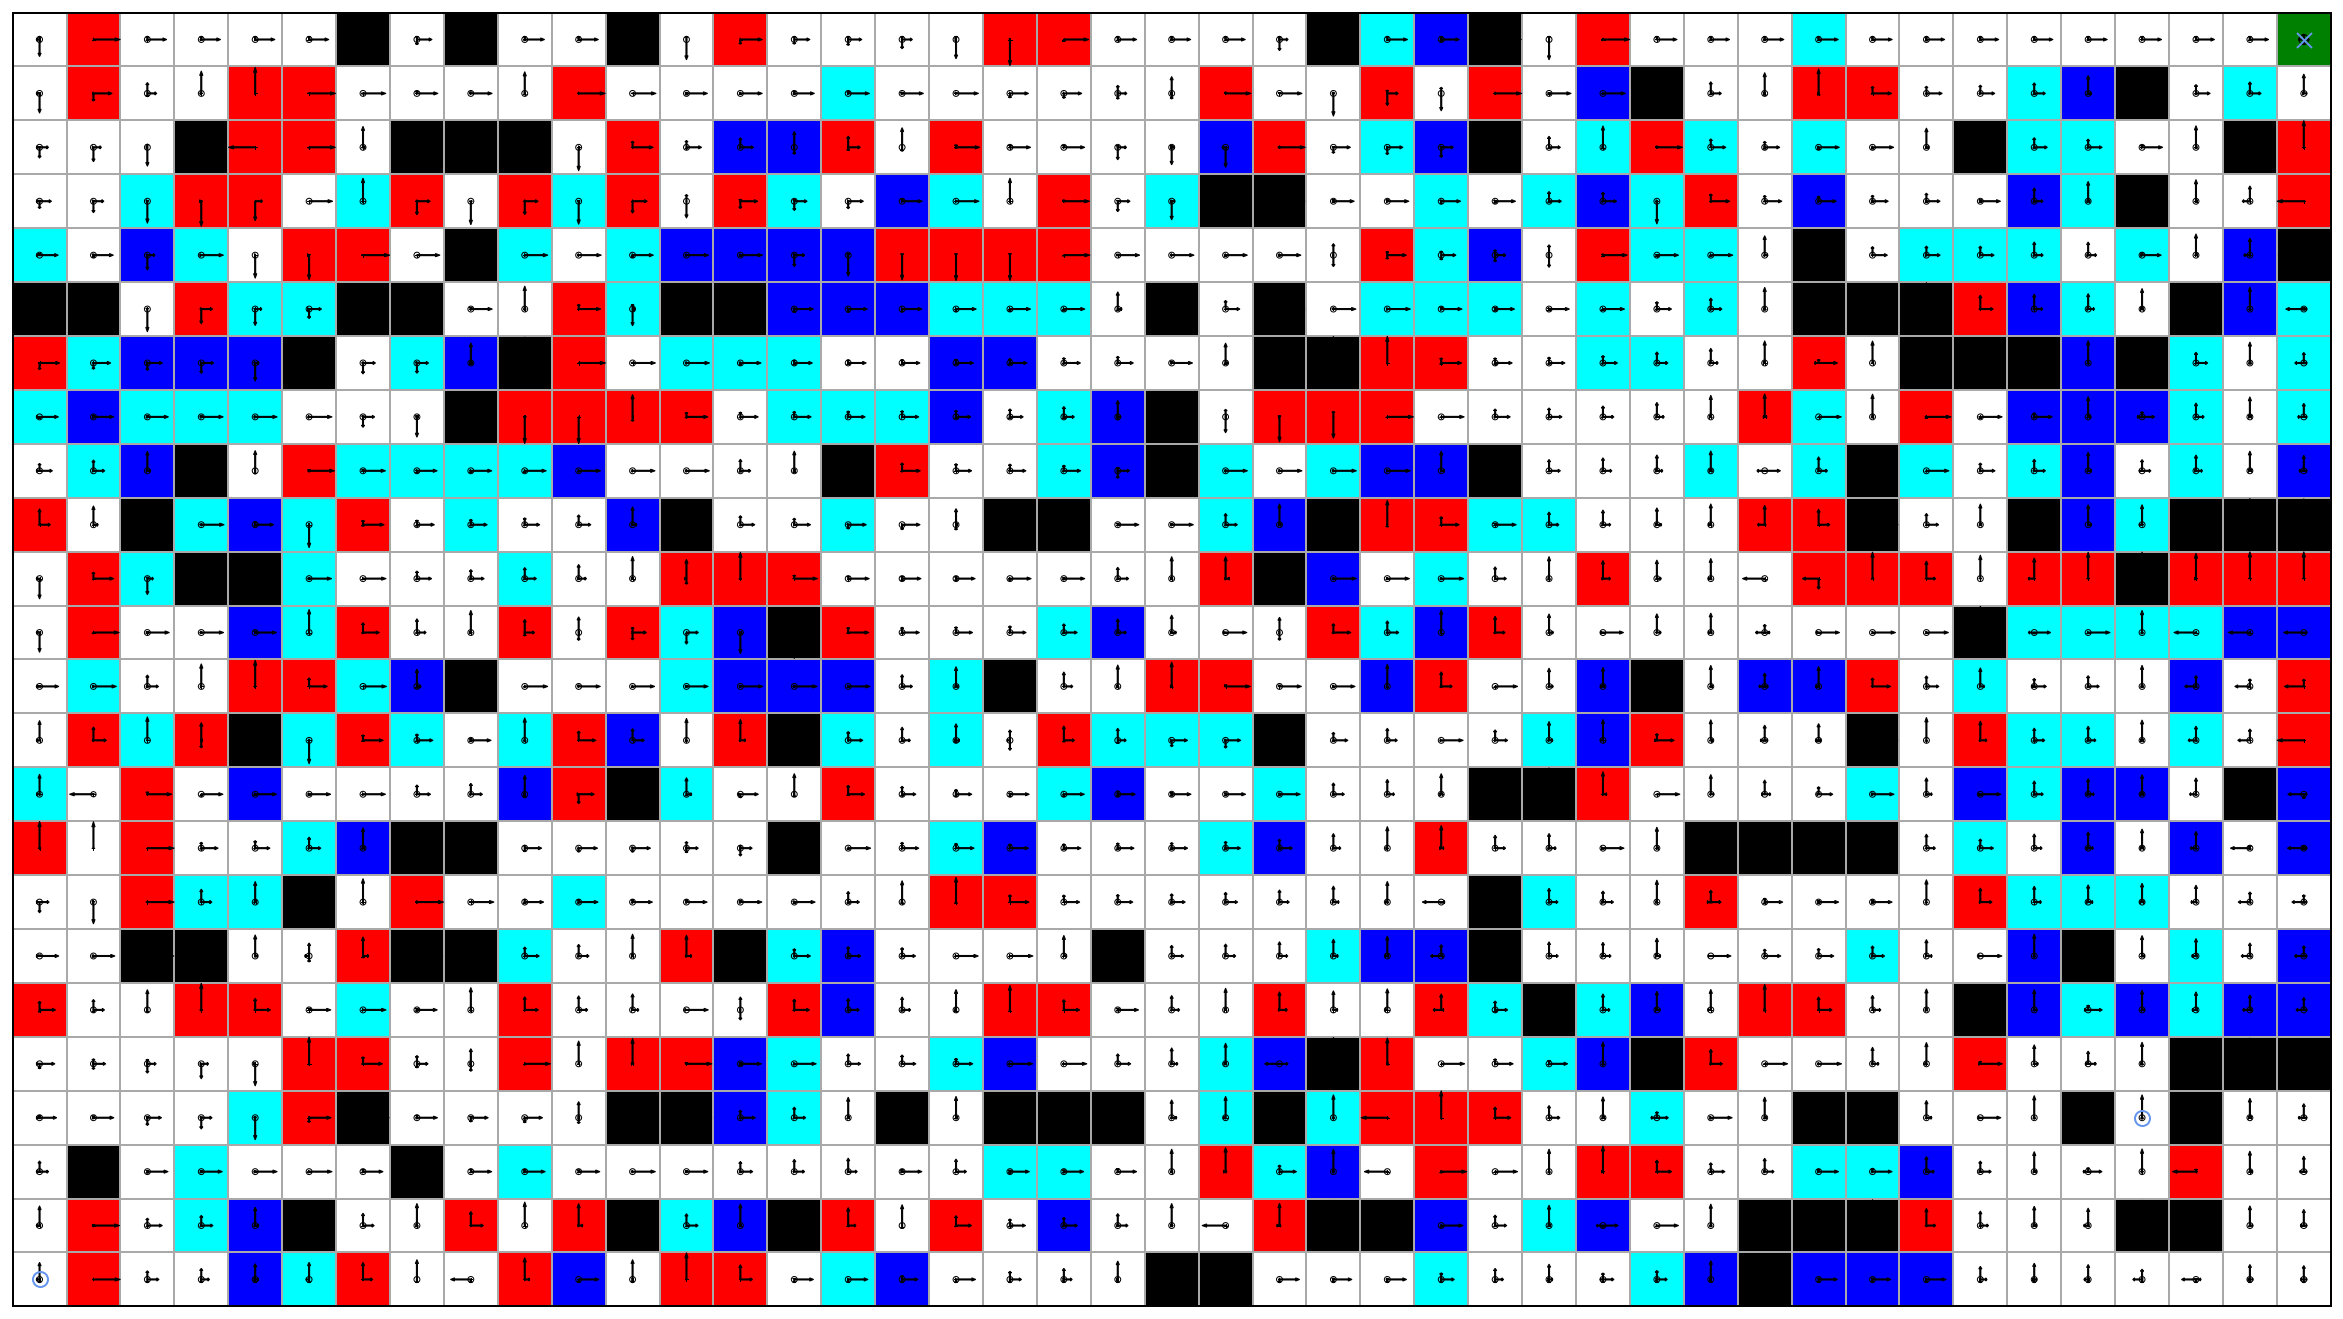

In [16]:
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=torch.tensor(mdp2.reward_matrix),
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([2]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)


In [18]:
features_dataset2 = FeaturesDataset(mdp2, trajectories, transform=ToTensor())

Learned Policy Initial Value: -181606.8010947675

Softmax Policy Initial Value: -59.731446903055634


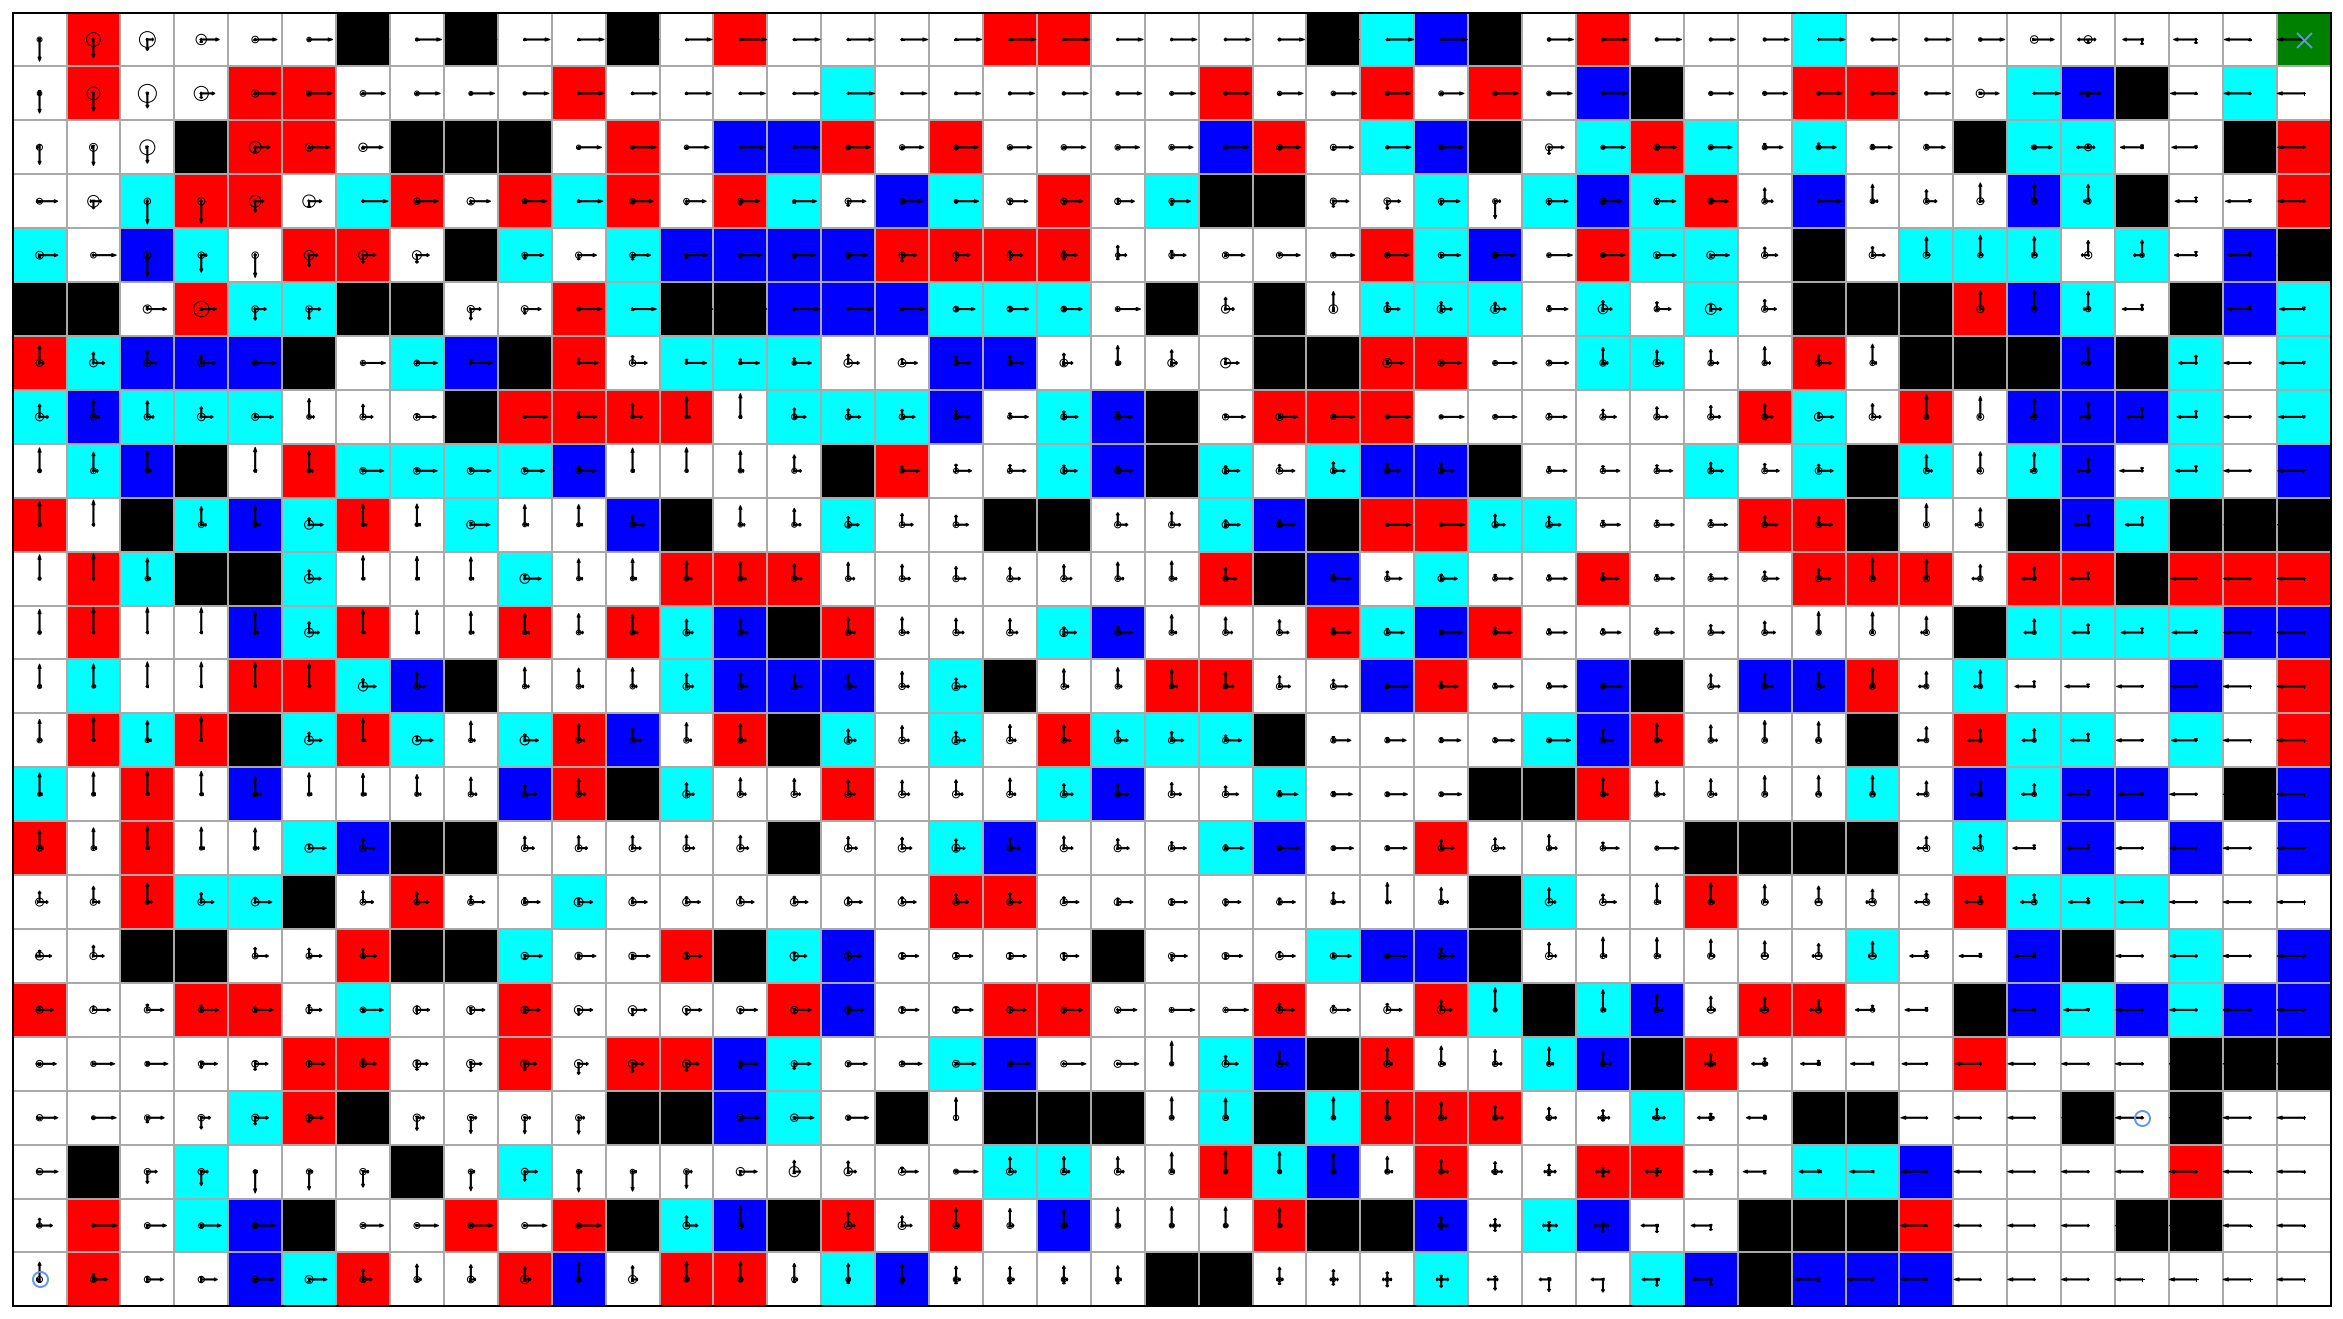

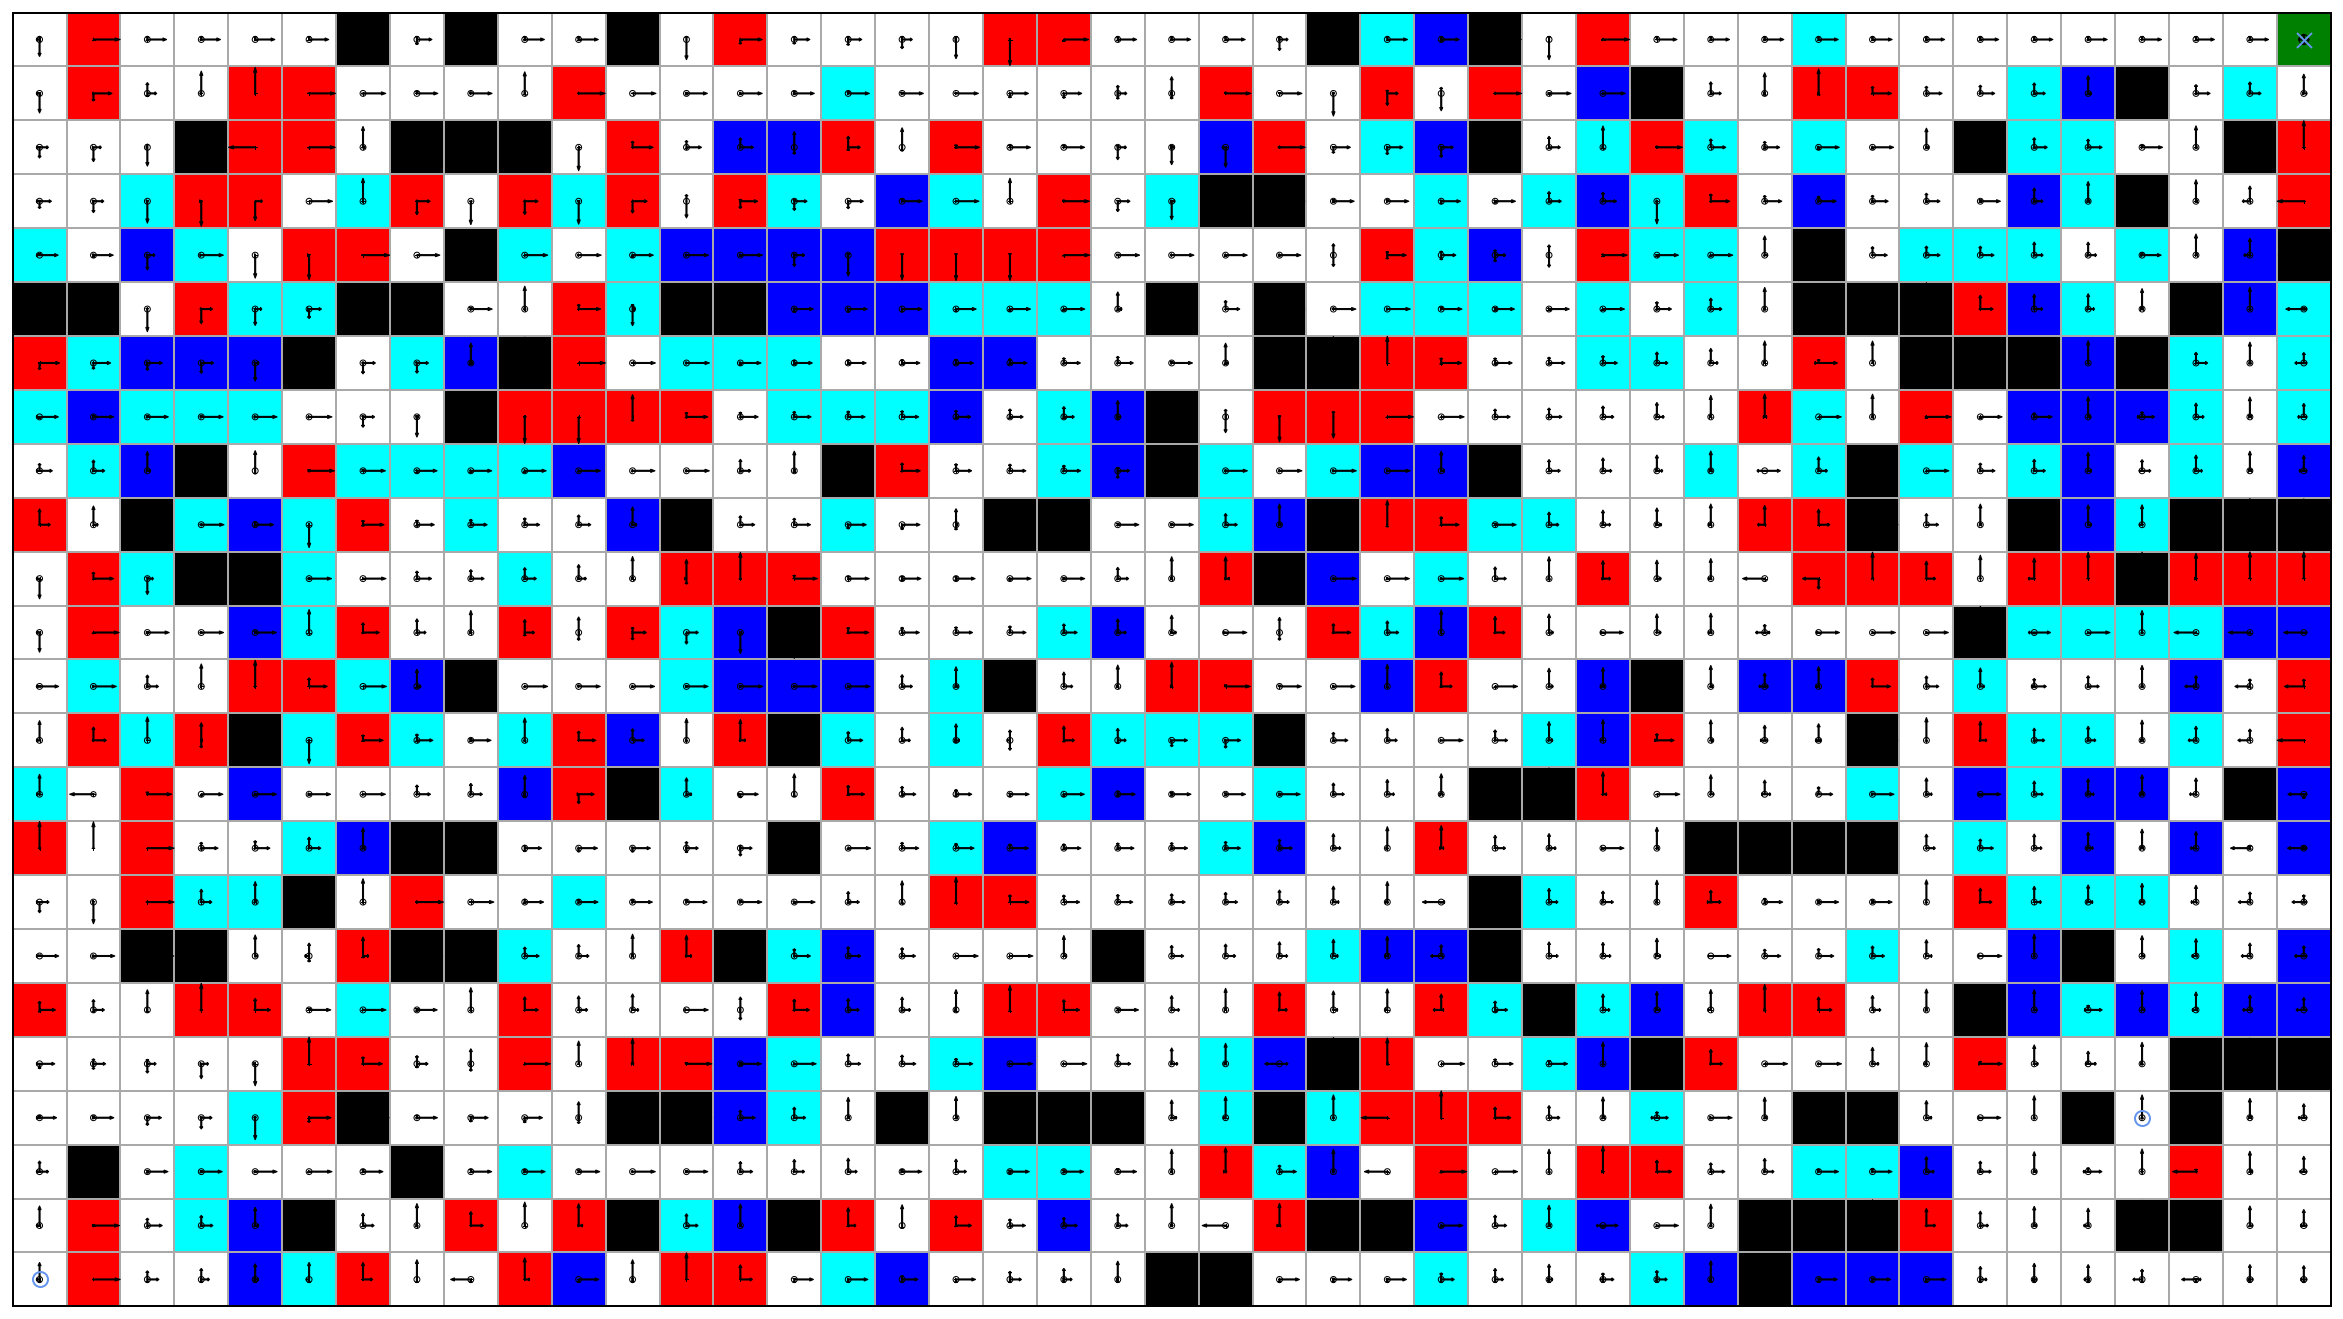

In [19]:
optimized_model.eval()

# so pred doesn't have a grad_fn attached to it
with torch.no_grad():
  for s in mdp2.state_list:
    state_feature = torch.from_numpy(np.array([features_dataset2.getStateFeature(s)], dtype='f')).to(device)
    # pred = model(state_feature)[0]
    pred = optimized_model(state_feature)
    probs = softmax_fn(pred)[0]
    policy[s] = {}
    # for each action in each state, grab from the "pred" result the probability of taking this action in this state and add that to the dictionary policy which is a dictionary with states as keys and a dictionary of "action: prob of taking this action in this state" as values
    for a_i, prob in enumerate(probs):
      policy[s][int_to_action[a_i]] = prob.item()

# to turn policy into an actual policy object that we can call the MSDM functions on
policy = TabularPolicy({s: DictDistribution(ap) for s, ap in policy.items()})
mdp2.plot(featurecolors=featurecolors).plot_policy(policy)
mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)

print(f"Learned Policy Initial Value: {policy.evaluate_on(mdp2).initial_value}")
print()
print(f"Softmax Policy Initial Value: {expert_policy.evaluate_on(mdp2).initial_value}")
